In [1]:
import tensorflow as tf
import numpy as np
from Utils import NotebookFinder
import matplotlib.pyplot as plt
from Configuration import printPeriodic,setDbgPrint,null
from data_Generator import data_Generator
import sys

sys.meta_path.append(NotebookFinder())

importing Jupyter notebook from Configuration.ipynb
importing Jupyter notebook from data_Generator.ipynb


In [2]:
sim = {
    'cfg' : {
        'run' : { # run parameters
            'numEpisodes'    : 1, # 1,        # num. of episodes to run
            'maxSteps'       : 100,         # max. num. of sim. steps
            'startLearnStep' : 200,           # start periodic training after this step num.
            'learnPeriod'    : 5,             # num. of steps between (re)training
            'dbgPrint'       : printPeriodic, # function or string name of function for debug print output
            'statusPeriod'   : 100,           # output program status at this interval
        },
        'dqn': {  # DQN parameters
            'learningRate': 0.01,  # please provide summary comments for each parameter
            'rewardDecay': 0.9,
            'eGreedy': 1,
            'eGreedyincrement': 0.005,  # Change the e_greedy value
            'replaceTargetIter': 200,
            'memorySize': 2000,
        }
    }
}

In [3]:
class run():
    def __init__(self ):
        self.actions = [
            "Channel_1",
            "Channel_6",
            "Channel_11"
        ]
        self.n_actions = len(self.actions)
        self.n_features = 3
        self.built_net()
        self.sess = tf.Session()
        self.saver = tf.train.Saver()
        self.saver.restore(self.sess, 'my_net/my_test_model.ckpt') #Load parameter
        self.params = []
        self.cost_his = []
        self.time = 0
        self.time_env_state = {}
        self.num = 0
        self.list = data_Generator()
        self.reward_history = []
        self.action_history = []
    def built_net(self):
        # Reconstruction neural network model.Only one of the neural networks is kept here.
        c_names, n_l1, w_initializer, b_initializer = ['target_net_params', tf.GraphKeys.GLOBAL_VARIABLES], 10, \
                                                      tf.random_normal_initializer(0., 0.3), tf.constant_initializer(0.1)
        self.env_state_ = tf.placeholder(tf.float32, [None, self.n_features], name='env_state_')
        with tf.variable_scope('target_net'):
            c_names = ['target_net_params', tf.GraphKeys.GLOBAL_VARIABLES]

            with tf.variable_scope(
                    'l1'):
                w1 = tf.get_variable('w1', [self.n_features, n_l1], initializer=w_initializer, collections=c_names)
                b1 = tf.get_variable('b1', [1, n_l1], initializer=b_initializer, collections=c_names)
                l1 = tf.nn.tanh(tf.matmul(self.env_state_, w1) + b1)
            with tf.variable_scope('l2'):
                w2 = tf.get_variable('w2', [n_l1, self.n_actions], initializer=w_initializer, collections=c_names)
                b2 = tf.get_variable('b2', [1, self.n_actions], initializer=b_initializer, collections=c_names)
                self.q_next = tf.matmul(l1, w2) + b2

    def choose_action(self, env_state):
        env_state = env_state[np.newaxis, :]
        actions_value = self.sess.run(self.q_next,feed_dict={self.env_state_: env_state})
        action = np.argmax(actions_value)
        return action
    def data(self):

        channel = self.list[self.num]
        self.num +=1
        return channel

    def reset(self):
        self.update_State()
        # self.state = "Channel_1"
        return self.time_env_state["current"]


    def update_State(self):
        self.time += 1
        filename = 'data.csv'

        self.time_env_state["current"] = {"Channel_1": self.data(),
                                          "Channel_6": self.data(),
                                          "Channel_11": self.data(), }

        return self.time_env_state["current"]
    def step(self,action):
        value = 0
        min_value = np.Inf
        action_key = ""

       # self.log('{}: action {} has min. value {}\n'.format(self.time, action_key, min_value), period=self.statusPeriod,
                # counter=self.time)


        for key in self.time_env_state["current"]:

            value = self.time_env_state["current"][key][0]
            if value < min_value:
                min_value = value
                action_key = key
        #reward = self.reward(action)
        if action_key == action:
            self.reward = 5
        else:
            self.reward = 0
        self.reward_history.append(self.reward)
        # self.correct_rate.append(self.count/(len(self.count_history)))
        next_state = action
        self.state = next_state
        self.update_State()

        return self.time_env_state["current"], self.time_env_state["current"][next_state]
    def run_(self,cfg=None):
        numEpisodes = cfg['numEpisodes']
        maxSteps = cfg['maxSteps']
        dbgPrint = cfg.get('dbgPrint', null)

        statusPeriod = cfg.get('statusPeriod', 1)
        for episode in range(1,numEpisodes+1):
            # initial observation
            step = 0
            env_state_1 = self.reset()
            while step < maxSteps:
                print('{}: current env = {}\n'.format(self.time, self.time_env_state))
                env_state = np.hstack((env_state_1["Channel_1"], env_state_1["Channel_6"],
                                       env_state_1["Channel_11"]))

                action = self.choose_action(env_state)
                if action == 0:
                    action_ = "Channel_1"
                    self.action_history.append(1)
                elif action == 1:
                    action_ = "Channel_6"
                    self.action_history.append(6)
                else:
                    action_ = "Channel_11"
                    self.action_history.append(11)
                observation = env_state_1[action_]
                dbgPrint('{}: action_ = {}, observation = {}\n'.format(self.time, action_, observation),
                         period=statusPeriod, counter=self.time)
                print('{}: action_ = {}, observation = {}\n'.format(self.time, action_, observation))
                env_state_, observation_ = self.step(action_)
                env_state_ = np.hstack(( env_state_["Channel_1"],  env_state_["Channel_6"],
                                env_state_["Channel_11"]))
                env_state_ = {"Channel_1": env_state_[0:1],
                              "Channel_6": env_state_[1:2],
                              "Channel_11": env_state_[2:3]

                              }
                env_state_1 = env_state_
                step += 1


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from my_net/my_test_model.ckpt
1: current env = {'current': {'Channel_1': array([0.5]), 'Channel_6': array([0.5]), 'Channel_11': array([1.])}}

1: action_ = Channel_6, observation = [0.5]

2: current env = {'current': {'Channel_1': array([0.53139526]), 'Channel_6': array([0.5]), 'Channel_11': array([0.99901336])}}

2: action_ = Channel_6, observation = [0.5]

3: current env = {'current': {'Channel_1': array([0.56266662]), 'Channel_6': array([0.5]), 'Channel_11': array([0.99605735])}}

3: action_ = Channel_6, observation = [0.5]

4: current env = {'current': {'Channel_1': array([0.59369066]), 'Channel_6': array([0.5]), 'Channel_11': array([0.99114363])}}

4: action_ = Channel_6, observation = [0.5]

5: current env = {'current': {'Channel_1': array([0.62434494]), 'Channel_6': array([0.5]), 'Chan

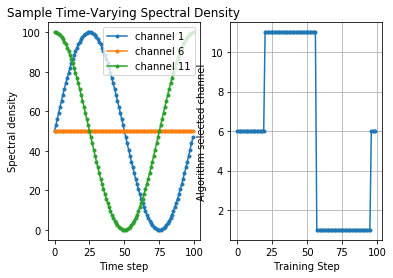

In [4]:
if __name__ == "__main__":
    statusPeriod = sim['cfg']['run']['statusPeriod']
    dbgPrint = setDbgPrint(sim['cfg']['run'].get('dbgPrint'))
    #env = Env(log=dbgPrint, statusPeriod= statusPeriod)
    run = run()
    run.run_(cfg=sim['cfg']['run'])
    plt.subplot(1,2 ,1 )
    N = 100
    specHi = 50 + 50 * np.sin(2 * np.pi * np.arange(N) / N)
    spec1 = np.array([50] * N)
    spec2 = 50 + 50 * np.cos(2 * np.pi * np.arange(N) / N)
    plt.plot(np.c_[specHi, spec1, spec2], '.-')
    plt.xlabel('Time step')
    plt.ylabel('Spectral density')
    plt.legend(['channel 1', 'channel 6', 'channel 11'])
    plt.title('Sample Time-Varying Spectral Density')
    plt.subplot(1, 2, 2)
    plt.plot(run.action_history, '.-')
    plt.xlabel('Training Step')
    plt.ylabel('Algorithm selected channel')
    plt.grid(True)
    plt.show()